# 12. Training with Michel and OD Veto Removed
## Run Details:
- Dataset: 
- Test Goals: 
- Results Summary: 

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm
from repeating_classifier_training_utils import *

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

## Set Run Directories Here

In [2]:
dump_dir = '/home/cmacdonald/CNN/dumps/'

path_1 = os.path.join(dump_dir,'20200724_164640_nomichel_3class')
preferred_run_idx = 0
paths = list([path_1])
run_names=['OD Veto and Michel Events Removed']
cut_names= [['fq_failed', 'fq_flag']]

idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_nomichel_pe_idxs.npz']

idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_extra.npz' for _ in range(4)]

npz_path = os.path.join(os.getcwd(),'Index_Storage')

LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
legend_label_dict={'e':'e-','gamma':'\u03B3', 'mu':'\u03BC-'}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

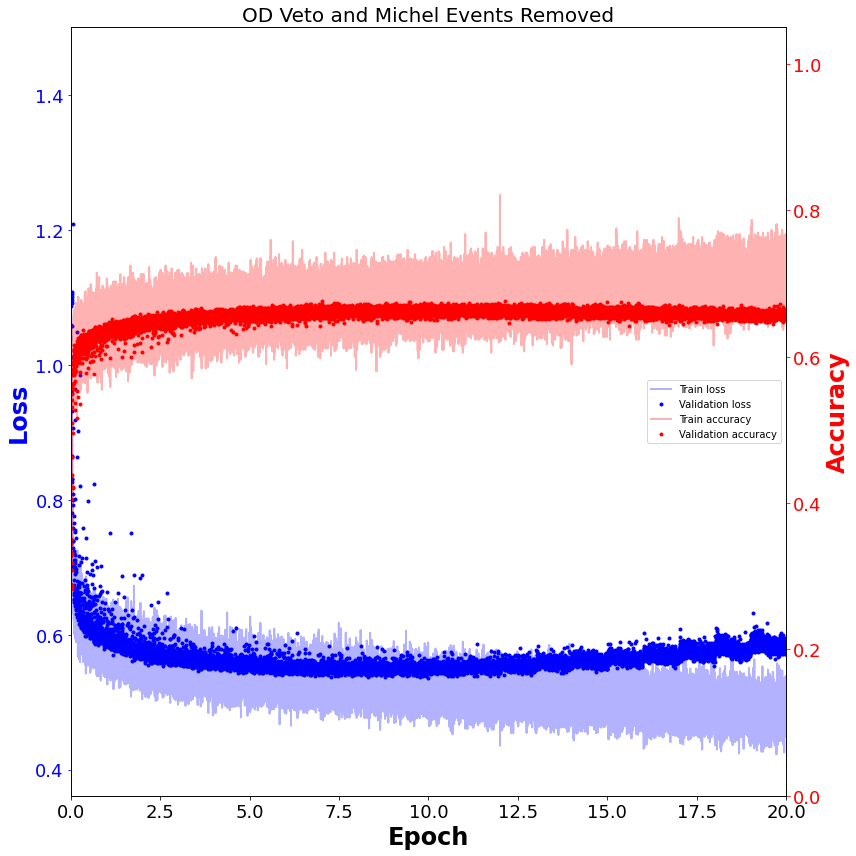

In [3]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=run_names,leg_font=10, title_font=20)

## Plot Confusion Matrices

In [4]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),np.load(idx_file_paths[i])['test_idxs'], cut_names[i]) 
               for i,loc in enumerate(paths)]

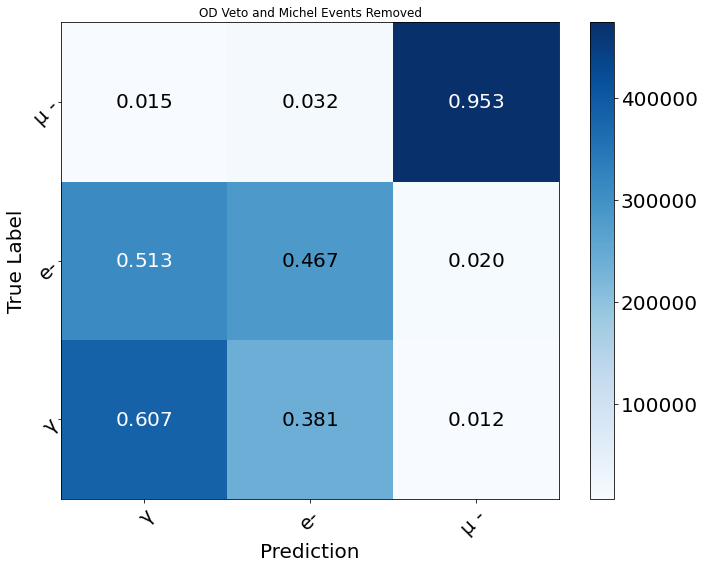

In [5]:
fig = plot_multiple_confusion_matrix([output['labels'] for output in test_output], [output['predicted_labels'] for output in test_output],
                               ['\u03B3','e-','\u03BC -'],titles=run_names)

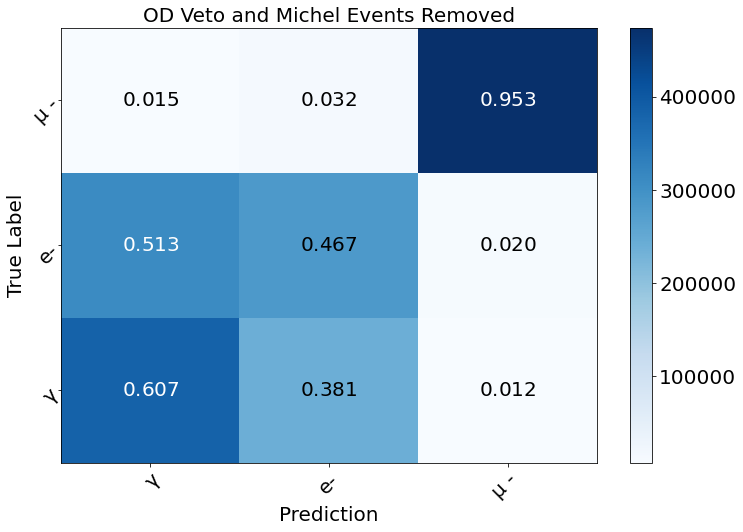

In [6]:
preferred_run=test_output[preferred_run_idx]
plot_confusion_matrix(preferred_run['labels'],preferred_run['predicted_labels'],['\u03B3','e-','\u03BC -'],title=run_names[preferred_run_idx])


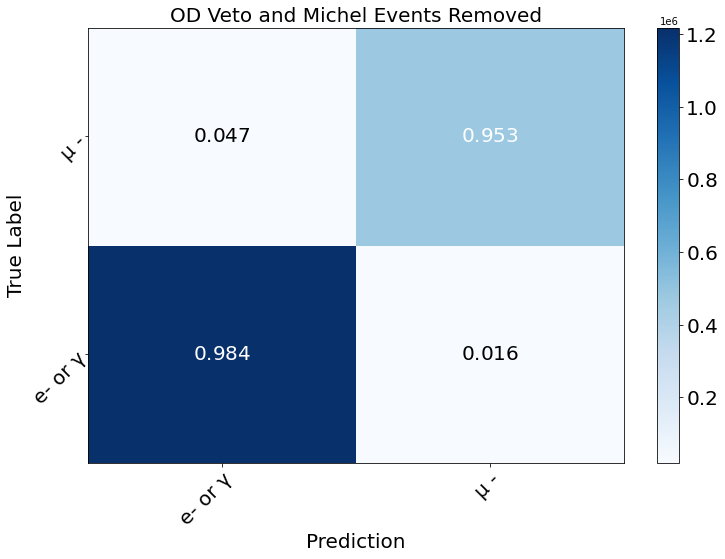

In [7]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict,
                                                                 predictions = preferred_run['predicted_labels'])
fig = plot_confusion_matrix(collapsed_labels_1-1,collapsed_predictions_1-1,
                            ['e- or \u03B3','\u03BC -'],title=run_names[preferred_run_idx])

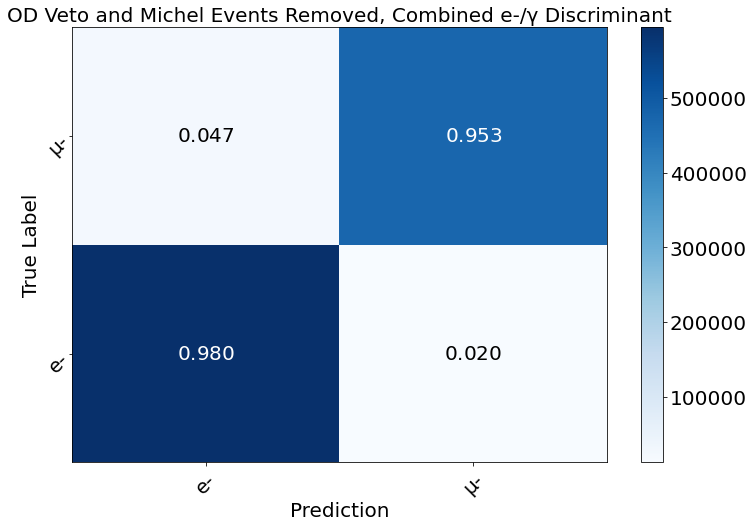

In [8]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict,
                                                                 predictions = preferred_run['predicted_labels'])
emu_idxs = np.where(preferred_run['labels']!=0)[0]
fig = plot_confusion_matrix(collapsed_labels_1[emu_idxs]-1,collapsed_predictions_1[emu_idxs]-1,
                            ['e-','\u03BC-'],title=f'{run_names[preferred_run_idx]}, Combined e-/\u03B3 Discriminant')

## ROC Curves

In [9]:
fq_rootfiles, fq_eventids, fq_flag, fq_scores, fq_mom, fq_labels = load_fq_output(os.path.join(npz_path,'fq_mapping_idxs.npz'), os.path.join(npz_path,'fq_failed_idxs.npz'), idx_file_paths[preferred_run_idx], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[0])

In [10]:
pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(fq_rootfiles))
pbar.start()
for i in range(len(fq_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == preferred_run['rootfiles'][i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == preferred_run['eventids'][i]
    pbar.update(i)
pbar.finish()
assert len(preferred_run['rootfiles']) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

/home/prouse/scratch/IWCDmPMT_4pi_full_tank/fiTQun/e-/E0to1000MeV/unif-pos-R371-y521cm/4pi-dir/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_105_fiTQun.root


AssertionError: None

In [ ]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","gamma",energies=output['energies']) for output in test_output]+
                                [prep_roc_data(-fq_scores,fq_labels,
                                'rejection',softmax_index_dict,"e","gamma")])

In [ ]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names+['FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False,legend_label_dict=legend_label_dict)

In [ ]:
collapsed_info = [collapse_test_output(run['softmax'],run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma") for run in test_output]

collapsed_scores = [info[0] for info in collapsed_info]
collapsed_labels = [info[1] for info in collapsed_info]
fprs, tprs, thresholds = zip(*[prep_roc_data(collapsed_scores[i],collapsed_labels[i], 'rejection',softmax_index_dict, "e","mu") for i in range(len(collapsed_info))]+
                                [prep_roc_data(fq_scores,fq_labels,'rejection',softmax_index_dict,"e","mu")]
                            )

In [ ]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"], 
                                plot_labels = run_names+['FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                 xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection',legend_label_dict=legend_label_dict)
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))

## Signal Purity vs Energy At Fixed Efficiency

In [ ]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
f=h5py.File('/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5', 'r')
energies=np.array(f['energies'])
labels=np.array(f['labels'])

for i, run in enumerate(test_output):
    shifted_energies = []
    
    idxs = np.load(idx_file_paths[i],allow_pickle=True)['test_idxs']
    run_labels=labels[idxs]
    run_energies=energies[idxs]
    
    shifted_energies = np.zeros(run_labels.shape[0])
    
    g_idxs = np.where(run_labels==0)[0]
    e_idxs = np.where(run_labels==1)[0]
    m_idxs = np.where(run_labels==2)[0]
    shifted_energies[g_idxs] = np.squeeze(run_energies[g_idxs] - GAMMA_THRESHOLD)
    shifted_energies[e_idxs] = np.squeeze(run_energies[e_idxs] - ELECTRON_THRESHOLD)
    shifted_energies[m_idxs] = np.squeeze(run_energies[m_idxs] - MUON_THRESHOLD)
    run['shifted_energies'] = apply_cuts(shifted_energies, idxs, os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[i])

In [ ]:
shifted_energies = []
    
idxs = np.load(idx_file_paths[0],allow_pickle=True)['test_idxs']
run_labels=labels[idxs]
run_energies=energies[idxs]

shifted_energies = np.zeros(run_labels.shape[0])

g_idxs = np.where(run_labels==0)[0]
e_idxs = np.where(run_labels==1)[0]
m_idxs = np.where(run_labels==2)[0]
shifted_energies[g_idxs] = np.squeeze(run_energies[g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(run_energies[e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(run_energies[m_idxs] - MUON_THRESHOLD)
fq_shifted_energies = apply_cuts(shifted_energies, idxs, os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[0])

In [ ]:
##Binning in Energy
scores = [run['softmax'] for run in test_output]

labels = [run['labels'] for run in test_output]
binning_features = [run['shifted_energies'] for run in test_output]
feature_label = 'Energy above Cherenkov Threshold (MeV)'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
style = ['-','--','-.','-.','-',':','--']

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(scores):
    plot_binned_performance(softmax,
            labels[i],
            binning_features[i],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[i%7],color=colors[i%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict) 

plot_binned_performance(-fq_scores,
            fq_labels,
            fq_shifted_energies,           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[len(scores)%7],color=colors[len(scores)%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)
    
collapsed_info = [collapse_test_output(run['softmax'],run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma") for run in test_output]

collapsed_scores = [info[0] for info in collapsed_info]
collapsed_labels = [info[1] for info in collapsed_info]

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(collapsed_scores):
    plot_binned_performance(softmax,
            collapsed_labels[i],
            binning_features[i][np.where(labels[i]!=0)[0]],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','mu',metric='inverse fpr',marker=style[i%7],color=colors[i%7],ax=ax,title_note=f", P(e-) + P({legend_label_dict['gamma']})", legend_label_dict=legend_label_dict) 

plot_binned_performance(fq_scores,
            fq_labels,
            fq_shifted_energies,           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','mu',metric='inverse fpr',marker=style[len(scores)%7],color=colors[len(scores)%7],ax=ax,title_note=f", P(e-) + P({legend_label_dict['gamma']})" , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)

In [ ]:
d_to_wall_incl_all = np.load('dist_to_wall.npz')['test_d_to_wall']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

idx_dic = {}
for i, idx in enumerate(test_filtered_indices):
    idx_dic[idx] = i

test_idxs_list = [np.load(idx_file_path, allow_pickle=True)['test_idxs'] for idx_file_path in idx_file_paths]

keep_idxs_list = []

for test_idxs in test_idxs_list:
    keep_idxs = []
    for idx in test_idxs:
        try:
            keep_idxs.append(idx_dic[idx])
        except KeyError:
            pass
    keep_idxs_list.append(keep_idxs)

dtowall_list = [apply_cuts(d_to_wall_incl_all[keep_idxs], test_idxs_list[i], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),cut_names[i]) for i, keep_idxs in enumerate(keep_idxs_list)]

In [ ]:
scores = [run['softmax'] for run in test_output]

labels = [run['labels'] for run in test_output]
binning_features = dtowall_list
feature_label = 'Distance to Wall Along Particle Trajectory'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
style = ['-','--','-.','-.','-',':','--']

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(scores):
    plot_binned_performance(softmax,
            labels[i],
            binning_features[i],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[i%7],color=colors[i%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict) 

plot_binned_performance(-fq_scores,
            fq_labels,
            binning_features[preferred_run_idx],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[len(scores)%7],color=colors[len(scores)%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)
    
collapsed_info = [collapse_test_output(run['softmax'],run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma") for run in test_output]

collapsed_scores = [info[0] for info in collapsed_info]
collapsed_labels = [info[1] for info in collapsed_info]

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(collapsed_scores):
    plot_binned_performance(softmax,
            collapsed_labels[i],
            binning_features[i][np.where(labels[i]!=0)[0]],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','mu',metric='inverse fpr',marker=style[i%7],color=colors[i%7],ax=ax,title_note=f", P(e-) + P({legend_label_dict['gamma']})", legend_label_dict=legend_label_dict) 

plot_binned_performance(fq_scores,
            fq_labels,
            binning_features[preferred_run_idx],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','mu',metric='inverse fpr',marker=style[len(scores)%7],color=colors[len(scores)%7],ax=ax,title_note=f", P(e-) + P({legend_label_dict['gamma']})" , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)

In [ ]:
#Binning in origin radius squared
test_radius_incl_all = np.load('event_radii.npz')['test_radii']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

idx_dic = {}
for i, idx in enumerate(test_filtered_indices):
    idx_dic[idx] = i


test_idxs_list = [np.load(idx_file_path, allow_pickle=True)['test_idxs'] for idx_file_path in idx_file_paths]

keep_idxs_list = []

for test_idxs in test_idxs_list:
    keep_idxs = []
    for idx in test_idxs:
        try:
            keep_idxs.append(idx_dic[idx])
        except KeyError:
            pass
    keep_idxs_list.append(keep_idxs)

test_radius_list = [apply_cuts(test_radius_incl_all[keep_idxs], test_idxs_list[i], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),cut_names[i]) for i, keep_idxs in enumerate(keep_idxs_list)]

In [ ]:
scores = [run['softmax'] for run in test_output]

labels = [run['labels'] for run in test_output]
binning_features = [radius**2 for radius in test_radius_list]
feature_label = 'Event Origin Radius Squared (cm^2)'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
style = ['-','--','-.','-.','-',':','--']

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(scores):
    plot_binned_performance(softmax,
            labels[i],
            binning_features[i],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[i%7],color=colors[i%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict) 

plot_binned_performance(-fq_scores,
            fq_labels,
            binning_features[preferred_run_idx],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[len(scores)%7],color=colors[len(scores)%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)
    
collapsed_info = [collapse_test_output(run['softmax'],run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma") for run in test_output]

collapsed_scores = [info[0] for info in collapsed_info]
collapsed_labels = [info[1] for info in collapsed_info]

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(collapsed_scores):
    plot_binned_performance(softmax,
            collapsed_labels[i],
            binning_features[i][np.where(labels[i]!=0)[0]],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','mu',metric='inverse fpr',marker=style[i%7],color=colors[i%7],ax=ax,title_note=f", P(e-) + P({legend_label_dict['gamma']})", legend_label_dict=legend_label_dict) 

plot_binned_performance(fq_scores,
            fq_labels,
            binning_features[preferred_run_idx],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','mu',metric='inverse fpr',marker=style[len(scores)%7],color=colors[len(scores)%7],ax=ax,title_note=f", P(e-) + P({legend_label_dict['gamma']})" , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)

In [ ]:
#rest masses in MeV/c^2
E_REST_MASS = 0.510998
MUON_REST_MASS = 105.658
GAMMA_REST_MASS = 0
rest_masses = {softmax_index_dict['gamma']:GAMMA_REST_MASS, softmax_index_dict['e']:E_REST_MASS, softmax_index_dict['mu']:MUON_REST_MASS}
true_momentum = np.ones_like(preferred_run['energies'])
pbar = ProgressBar(widgets=['Find True Momentum: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
        ' ', ETA()], maxval=preferred_run['labels'].shape[0])
pbar.start()
for i, energy in enumerate(preferred_run['energies']):
    #true momentum in units of MeV/c
    pbar.update(i)
    true_momentum[i] = np.sqrt(energy**2 - rest_masses[preferred_run['labels'][i]]**2)
pbar.finish()

## Plot Classifier Response

In [ ]:
fig=plot_response(preferred_run['softmax'], preferred_run['labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),
                    legend_locs=['lower center', 'lower center', 'upper center','upper center'], 
                    extra_panes=[['e','gamma']], legend_label_dict=legend_label_dict)

In [ ]:
ns,bins = np.histogram(preferred_run['shifted_energies'], bins=5)
left_edges = bins[0:-1]
bin_assignments = np.digitize(preferred_run['shifted_energies'], left_edges)

In [ ]:
for BIN_NUM in range(1,6):
    bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
    fig = plot_response(preferred_run['softmax'][bin_idxs,:], preferred_run['labels'][bin_idxs], ['gamma','e','mu'], 
                        softmax_index_dict, extra_panes=[['e','gamma']],bins=30,linestyle=(':','-','--'), legend_label_dict=legend_label_dict,
                        legend_locs=['best', 'upper center', 'upper center','upper center'])
    
    a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(os.getcwd(),f'plot_images/resnet_1d_binned_response_bin{BIN_NUM}.pdf'))

In [ ]:
for i in range(fq_labels.shape[0]):
    assert fq_labels[i] == preferred_run['labels'][i]
assert fq_labels.shape[0] == preferred_run['labels'].shape[0]

## Plot Binned Response

In [ ]:
binning_features = [preferred_run['shifted_energies'], test_radius_list[preferred_run_idx]**2, dtowall_list[preferred_run_idx]]
binning_labels=['Energy above Cherenkov Threshold (MeV)','Radius Squared of Event Origin (cm^2)',
                'Trajectory Distance to Wall (cm)']

In [ ]:
img_names = ['2d_resnet_binned_response_energy.pdf','2d_resnet_binned_response_radius.pdf','2d_resnet_binned_response_dtowall.pdf']
for i in range(len(binning_features)):
    fig = plot_binned_response(preferred_run['softmax'],
            preferred_run['labels'],
            ['gamma','e','mu'],
            binning_features[i],           
            binning_labels[i],
            0.8, 30, 30,softmax_index_dict,
            extra_panes=[['e','gamma']],
            legend_label_dict=legend_label_dict,
            wrap_size=35
            )
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i])) 